In [65]:
import matplotlib as mpl
mpl.rcParams["axes.linewidth"] = 0
mpl.rcParams["xtick.major.size"] = 0
mpl.rcParams["ytick.major.size"] = 0
__gray = "#000000"
mpl.rcParams["xtick.color"] = __gray
mpl.rcParams["ytick.color"] = __gray
mpl.rcParams["axes.labelcolor"] = __gray
mpl.rcParams['font.size'] = 24
mpl.rcParams["axes.labelsize"] = 28
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams['legend.fontsize'] = 24
mpl.rcParams["font.family"] = "Myriad Pro"
mpl.rcParams["legend.frameon"] = False
%pylab inline

def area_under_sorted_points(x, y):
    bin_width = diff(x)
    y_avg = (y[:-1] + y[1:])/2
    return (y_avg * bin_width).sum()

from analysis import pareto, corrected_points, folder_names, conditions
print conditions
conditions = ["Control", "Margin", "Gamma Slider", "Perf Slider"]
print zip(conditions, folder_names)

Populating the interactive namespace from numpy and matplotlib
['Control', 'Margin', 'Gamma Slider', 'Performance Slider']
[('Control', './data/control/'), ('Margin', './data/margin/'), ('Gamma Slider', './data/robust_performance/'), ('Perf Slider', './data/robust_gamma/')]


In [3]:
figure(figsize=(12,8))
pointids_all = {}
for condition, folder in zip(conditions, folder_names):
    print folder
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    pps = pareto(pointids)
    pointids_all.update(pointids)
    pps_all.update(pps)
    xy = array(sorted(pps.keys()))
    x = xy[:,0]
    y = xy[:,1]
    for i in range(len(x)):
        min_idx = i
        if x[i] > 1100:
            break
    for i in range(len(x)-1,-1,-1):
        max_idx = i
        if x[i] < 1270:
            break
    print(min_idx, max_idx)
    x = x[min_idx:max_idx]
    y = y[min_idx:max_idx]
    area = area_under_sorted_points(x, y)
    print area
    plot(x, y, label=condition+": %i" % area)
    legend()
    grid(True)
    
condition = "Overall"
pps = pareto(pointids_all)
xy = array(sorted(pps))
x = xy[:,0]
y = xy[:,1]
for i in range(len(x)):
    min_idx = i
    if x[i] > 1100:
        break
for i in range(len(x)-1,-1,-1):
    max_idx = i
    if x[i] < 1270:
        break
print(min_idx, max_idx)
x = x[min_idx:max_idx]
y = y[min_idx:max_idx]
area = area_under_sorted_points(x, y)
print area
plot(x, y, label=condition+": %i" % area)
legend()
grid(True)

./data/control/


NameError: name 'pps_all' is not defined

In [2]:
pointids_all = {}
for condition, folder in zip(conditions, folder_names):
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    pps = pareto(pointids)
    pointids_all.update(pointids)
    
condition = "Overall"
pps_all = pareto(pointids_all)
fail_perfs = {fail: perf for perf, fail in pps_all}
for fail in range(70,-1,-1):
    if fail not in fail_perfs:
#         print "failure rate of", fail, "not achieved!"
        fail_perfs[fail] = fail_perfs[fail+1]
        
# xy = array(sorted(fail_perfs.items()))
# y = xy[:,0]
# x = xy[:,1]
# area = 0
# print area
# plot(x, y, label=condition+": %i" % area)
# legend()
# grid(True)

# figure(figsize=(12,8))
# for condition, folder in zip(conditions, folder_names):    
#     print folder
#     pointids, idpoints, pointnum, skipped = corrected_points(folder)
#     pps = pareto(pointids)
#     pointids_all.update(pointids)
#     pps_all.update(pps)
#     xy = array(sorted(pps.keys()))
#     y = xy[:,0]
#     x = xy[:,1]
#     best_y = array([fail_perfs[fail] for fail in x])
#     area = 100*(y/best_y - 1).mean()
#     print area
#     fill_between(x, best_y, y, label=condition+": %.2f" % area, alpha=0.3)
#     legend()
#     grid(True)

Control

Margin

Gamma Slider

Perf Slider



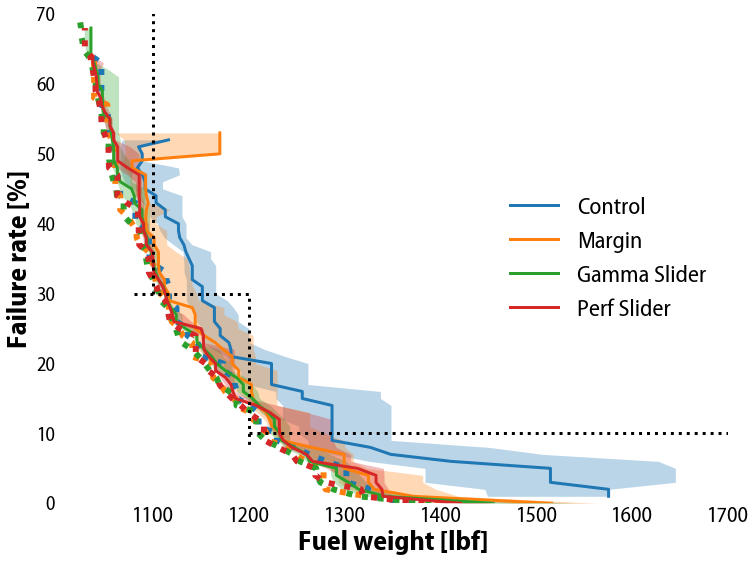

In [92]:
from collections import defaultdict
percents = defaultdict(list)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
k = 1
fig, ax = subplots(figsize=(12,9), facecolor="white")
lines = []
for k, (condition, folder) in enumerate(zip(conditions, folder_names)):
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    bestsbyfail = zeros((len(idpoints), 71))
    bestsbyfail.fill(inf)
    for j, (idn, points) in enumerate(idpoints.items()):
        pps = sorted(pareto({point: idn for point in points}).keys(), reverse=True)
        for i, (perf, fail) in enumerate(pps[:-1]):
            for f in range(int(fail), int(pps[i+1][1])):
                bestsbyfail[j, f] = perf
        for f in range(int(pps[-1][1]), 71):
            bestsbyfail[j, f] = inf
    x = range(0,71)
    y = nanmedian(bestsbyfail, axis=0)
    top = nanpercentile(bestsbyfail, 75, axis=0, interpolation="linear")
    top[top == inf] = y[top == inf]
    bot = nanpercentile(bestsbyfail, 25, axis=0, interpolation="linear")
    ax.fill_betweenx(x, bot, top, lw=0, color=colors[k], alpha=0.3)#, label=condition)
    line = ax.plot(y, x, "-", color=colors[k], label=condition, linewidth=3)
#     line = ax.plot(bot, x, "-", color=colors[k], linewidth=0.75)
    lines.append(line)
    ax.plot(nanmin(bestsbyfail, axis=0), x, ":", color=colors[k], linewidth=6)
    # fraction = 8/9.0
    # ax.plot([to[fraction*len(to)]], [y[fraction*len(to)]], shapes[problem], alpha=0.5,
    #     color=colors[tool], markeredgewidth=0.0)
    # ax.set_xlabel("Time since start [minutes]")
    ax.set_ylim([0, 70])
    # ax.set_ylabel("Cost (lower is better)")
    ax.set_xlim([1001, 1700])
    # savefig(f2, "progress_%s_%s_%s" % (manner, problem, tool))
    print
legend(loc="center right")
plt.box(on=None)
# title("Pareto frontier distribution (dashed line: best, solid: median, filled area: 25th to 75th percentile)")
ylabel("Failure rate [%]", fontweight='bold')
xlabel("Fuel weight [lbf]", fontweight='bold')
plot([1200, 2000], [10, 10], "k:", linewidth=3)
plot([1100, 1100], [30, 100], "k:", linewidth=3)
plot([1080, 1200, 1200], [30, 30, 8], "k:", linewidth=3)

Control

Margin

Gamma Slider

Perf Slider



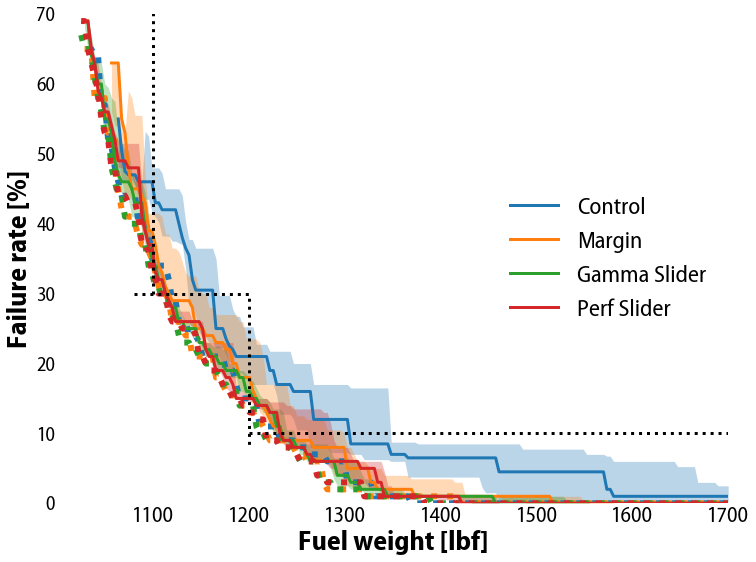

In [93]:
from scipy.interpolate import interp1d
from collections import defaultdict
percents = defaultdict(list)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
k = 1
fig, ax = subplots(figsize=(12,9), facecolor="white")
lines = []
xmin, xmax = 1000, 1700
x = linspace(xmin, xmax, 200)
interped = defaultdict(lambda: defaultdict(list))
for k, (condition, folder) in enumerate(zip(conditions, folder_names)):
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    bestsbyfail = zeros((len(idpoints), len(x)))
    bestsbyfail.fill(inf)
    for j, (idn, points) in enumerate(idpoints.items()):
        pps = sorted(pareto({point: idn for point in points}).keys(), reverse=True)
        perfs, fails = zip(*pps)
        perf_fails = interp1d(perfs, fails, kind="zero", bounds_error=False, fill_value=(inf, min(fails)))
        bestsbyfail[j] = perf_fails(x)
#         print perf_fails(to)
#     print bestsbyfail
    y = nanmedian(bestsbyfail, axis=0)
    top = nanpercentile(bestsbyfail, 75, axis=0, interpolation="linear")
    top[top == inf] = y[top == inf]
    bot = nanpercentile(bestsbyfail, 25, axis=0, interpolation="linear")
    ax.fill_between(x, bot, top, lw=0, color=colors[k], alpha=0.3)#, label=condition)
    line = ax.plot(x, y, "-", color=colors[k], label=condition, linewidth=3)
    lines.append(line)
    ax.plot(x, nanmin(bestsbyfail, axis=0), ":", color=colors[k], linewidth=6)
    # fraction = 8/9.0
    # ax.plot([to[fraction*len(to)]], [y[fraction*len(to)]], shapes[problem], alpha=0.5,
    #     color=colors[tool], markeredgewidth=0.0)
    # ax.set_xlabel("Time since start [minutes]")
    ax.set_ylim([0, 70])
    # ax.set_ylabel("Cost (lower is better)")
    ax.set_xlim([xmin+1, xmax])
    # savefig(f2, "progress_%s_%s_%s" % (manner, problem, tool))
    print
legend(loc="center right")
plt.box(on=None)
# title("Pareto frontier distribution (dashed line: best, solid: median, filled area: 25th to 75th percentile)")
ylabel("Failure rate [%]", fontweight='bold')
xlabel("Fuel weight [lbf]", fontweight='bold')
plot([1200, 2000], [10, 10], "k:", linewidth=3)
plot([1100, 1100], [30, 100], "k:", linewidth=3)
plot([1080, 1200, 1200], [30, 30, 8], "k:", linewidth=3)

Control

Margin


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: All-NaN slice encountered



Gamma Slider

Perf Slider



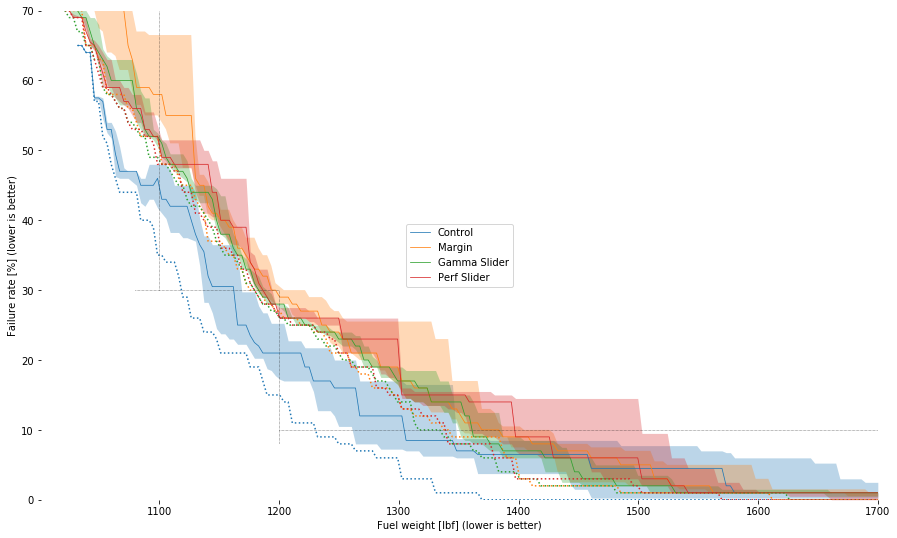

In [33]:
from analysis import get_points
from scipy.interpolate import interp1d
from collections import defaultdict
percents = defaultdict(list)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
k = 1
fig, ax = subplots(figsize=(15,9), facecolor="white")
lines = []
xmin, xmax = 1000, 1700
x = linspace(xmin, xmax, 200)
interped = defaultdict(lambda: defaultdict(list))
for k, (condition, folder) in enumerate(zip(conditions, folder_names)):
    print condition
    pointids, idpoints, pointnum = get_points(folder)
    bestsbyfail = zeros((len(idpoints), len(x)))
    bestsbyfail.fill(nan)
    for j, (idn, points) in enumerate(idpoints.items()):
        pps = sorted(pareto({point: idn for point in points}).keys(), reverse=True)
        perfs, fails = zip(*pps)
        perf_fails = interp1d(perfs, fails, kind="zero", bounds_error=False, fill_value=(nan, min(fails)))
        bestsbyfail[j] = perf_fails(x)
#         print perf_fails(to)
#     print bestsbyfail
    y = nanmedian(bestsbyfail, axis=0)
    top = nanpercentile(bestsbyfail, 75, axis=0, interpolation="linear")
    bot = nanpercentile(bestsbyfail, 25, axis=0, interpolation="linear")
    ax.fill_between(x, bot, top, lw=0, color=colors[k], alpha=0.3)#, label=condition)
    line = ax.plot(x, y, "-", color=colors[k], label=condition, linewidth=0.75)
    lines.append(line)
    ax.plot(x, nanmin(bestsbyfail, axis=0), ":", color=colors[k], linewidth=1.5)
    # fraction = 8/9.0
    # ax.plot([to[fraction*len(to)]], [y[fraction*len(to)]], shapes[problem], alpha=0.5,
    #     color=colors[tool], markeredgewidth=0.0)
    # ax.set_xlabel("Time since start [minutes]")
    ax.set_ylim([0, 70])
    # ax.set_ylabel("Cost (lower is better)")
    ax.set_xlim([xmin+1, xmax])
    # savefig(f2, "progress_%s_%s_%s" % (manner, problem, tool))
    print
legend(loc="center")
plt.box(on=None)
# title("Pareto frontier distribution (dashed line: best, solid: median, filled area: 25th to 75th percentile)")
ylabel("Failure rate [%] (lower is better)")
xlabel("Fuel weight [lbf] (lower is better)")
plot([1200, 2000], [10, 10], "k:", linewidth=0.5)
plot([1100, 1100], [30, 100], "k:", linewidth=0.5)
plot([1080, 1200, 1200], [30, 30, 8], "k:", linewidth=0.5)

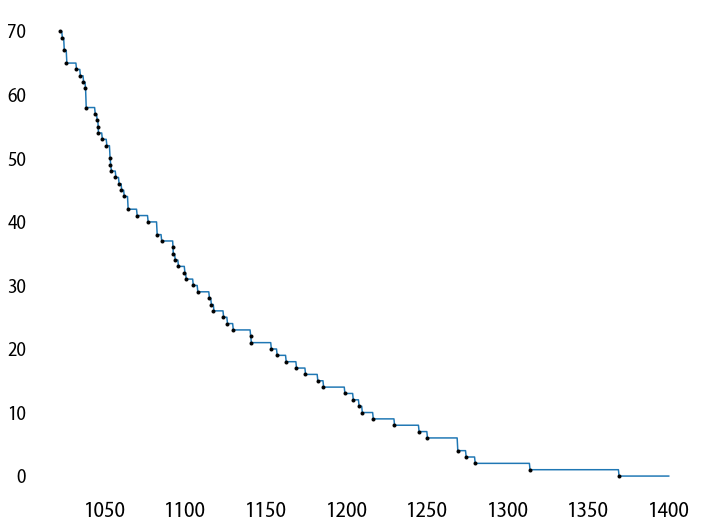

In [95]:
from scipy.interpolate import interp1d
perfs, fails = zip(*sorted(pps_all.keys()))
perf_fails = interp1d(perfs, fails, kind="zero",bounds_error=False, fill_value=(nan, 0))
x = linspace(1000, 1400, 1000)
fig, ax = subplots(figsize=(12,9), facecolor="white")
plot(x, perf_fails(x))
plot(perfs, fails, ".k")
# xlim(1320, 1400)

Control
  33    5.4%
  11    8.5%
  26    3.4%
  17   11.5%
   7   13.7%
  32    4.6%
  16    8.0%
  23    4.2%
   1    2.0%
  38    8.0%

Margin
  34    5.4%
  10   10.2%
  30    0.6%
  28    3.1%
  22    2.3%
   5    1.7%
   2    2.2%
  42    8.3%
  39    4.8%
  19    2.0%
  15    1.6%

Gamma Slider
   3    3.4%
  12    1.2%
  37    1.9%
  29    1.4%
  18    1.4%
  41    0.7%
  27    1.3%
  13    1.4%
   6    1.3%
  21    1.3%
  36    1.5%

Perf Slider
   4    1.6%
  25    0.6%
  35    2.6%
  24    1.4%
   8    2.8%
  43    0.6%
  31    1.8%
  14    1.1%
  40    1.5%
  20    0.9%
   9    1.6%

['Control', 'Margin', 'Gamma Slider', 'Perf Slider']
Control 4.30625 6.6923076923076925 8.375
Margin 1.8869395711500976 2.3043478260869565 5.0625
Gamma Slider 1.263768115942029 1.3529411764705883 1.4741379310344827
Perf Slider 1.0318840579710145 1.5 1.7314241486068112


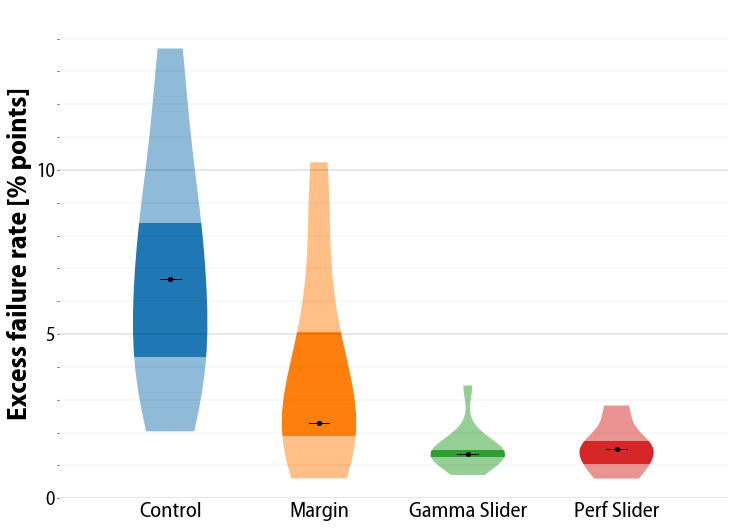

In [96]:
from collections import defaultdict
percents = defaultdict(list)
for condition, folder in zip(conditions, folder_names):   
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        pps = pareto({point: idn for point in points})
        total_percent_delta = 0
        for perf, fail in pps:
            total_percent_delta += fail - perf_fails(perf)
        total_percent_delta /= float(len(pps))
        print "  %2s  " % idn.split()[2][:-1], "%4.1f%%" % (total_percent_delta)
        percents[condition].append(total_percent_delta)
    print

fig, ax = subplots(figsize=(12,9), facecolor="white")
print [condition for condition in conditions]
data = [percents[condition] for condition in conditions]
plots = ax.violinplot(data, points=20, showextrema=False, showmedians=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, body in enumerate(plots["bodies"]):
    body.set_facecolor(colors[i])
    body.set_edgecolor("none")
    body.set_alpha(1)
for i, l in enumerate(data):
    l = array(l)
    lo = nanpercentile(l, 25, interpolation="linear")
    med = nanmedian(l)
    plot([i+0.93, i+1.07], [med, med], "-k", linewidth=1.0)
    plot([i+1, i+1], [med, med], "ok", markersize=4)
    hi = nanpercentile(l, 75, interpolation="linear")
    print conditions[i], lo, med, hi
    ax.fill_between([i+0.5, i + 1.5], hi, max(l), alpha=0.5,
                    edgecolor="none", facecolor="white")
    ax.fill_between([i+0.5, i + 1.5], 0, lo, alpha=0.5,
                    edgecolor="none", facecolor="white")
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

set_axis_style(ax, conditions)
ylabel("Excess failure rate [% points]", fontweight="bold")
ylim([0, 14.9])
mpl.rcParams["xtick.labelsize"] = 22
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="major", axis="y", linewidth=0.125, color="black")
ax.grid(which='minor', axis="y", linewidth=0.0625, color="black")
plt.box(on=None)

Control
  33   33.1%
  11   72.2%
  26   39.3%
  17   55.6%
   7   60.2%
  32   15.4%
  16   14.9%
  23   42.3%
   1   16.9%
  38   96.4%

Margin
  34   103.4%
  10   235.0%
  30    9.1%
  28   18.6%
  22    6.7%
   5   11.1%
   2   16.3%
  42   100.7%
  39   25.2%
  19   20.3%
  15   23.9%

Gamma Slider
   3   28.5%
  12    4.9%
  37   12.0%
  29   10.3%
  18    8.5%
  41    6.6%
  27    7.9%
  13    7.2%
   6   11.1%
  21    5.1%
  36   14.8%

Perf Slider
   4    8.5%
  25    3.1%
  35   91.8%
  24   15.6%
   8    8.7%
  43    8.1%
  31   14.1%
  14    5.2%
  40   31.9%
  20    5.8%
   9   113.4%

['Control', 'Margin', 'Gamma Slider', 'Perf Slider']
Control 20.979369760160694 40.84230824704826 59.058967308236426
Margin 13.66727132036699 20.291342306375952 62.978166106329226
Gamma Slider 6.902021495996008 8.549178356723134 11.518318665629101
Perf Slider 6.943411491531776 8.659415836582385 23.75732303205946


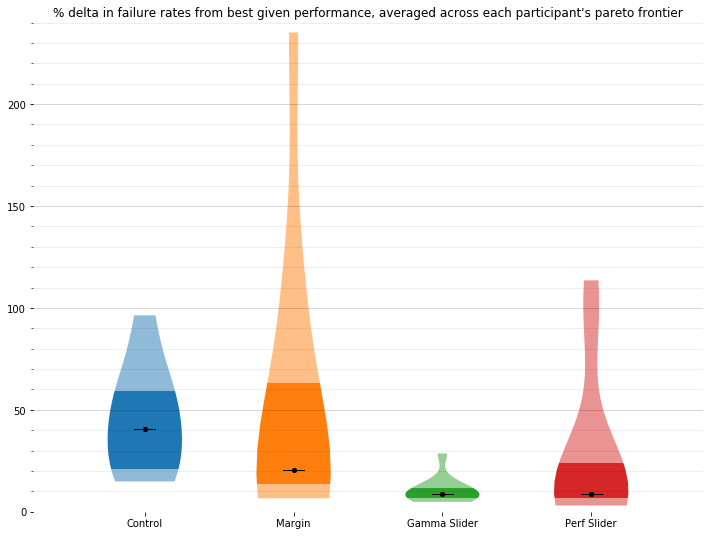

In [183]:
from collections import defaultdict
percents = defaultdict(list)
for condition, folder in zip(conditions, folder_names):   
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        pps = pareto({point: idn for point in points})
        total_percent_delta = 0
        for perf, fail in pps:
            if perf_fails(perf) == 0:
                continue
            total_percent_delta += fail/perf_fails(perf) - 1
        total_percent_delta /= float(len(pps))
        print "  %2s  " % idn.split()[2][:-1], "%4.1f%%" % (100*total_percent_delta)
        percents[condition].append(100*total_percent_delta)
    print

fig, ax = subplots(figsize=(12,9), facecolor="white")
print [condition for condition in conditions]
data = [percents[condition] for condition in conditions]
plots = ax.violinplot(data, points=20, showextrema=False, showmedians=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, body in enumerate(plots["bodies"]):
    body.set_facecolor(colors[i])
    body.set_edgecolor("none")
    body.set_alpha(1)
for i, l in enumerate(data):
    l = array(l)
    lo = nanpercentile(l, 25, interpolation="linear")
    med = nanmedian(l)
    plot([i+0.93, i+1.07], [med, med], "-k", linewidth=1.0)
    plot([i+1, i+1], [med, med], "ok", markersize=4)
    hi = nanpercentile(l, 75, interpolation="linear")
    print conditions[i], lo, med, hi
    ax.fill_between([i+0.5, i + 1.5], hi, max(l), alpha=0.5,
                    edgecolor="none", facecolor="white")
    ax.fill_between([i+0.5, i + 1.5], 0, lo, alpha=0.5,
                    edgecolor="none", facecolor="white")
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

set_axis_style(ax, conditions)
title("% delta in failure rates from best given performance, averaged across each participant's pareto frontier")
ylim([0, 240])
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.grid(which="major", axis="y", alpha=0.125, color="black")
ax.grid(which='minor', axis="y", alpha=0.08, color="black")
plt.box(on=None)

Control
  33    3.3%
  11    4.1%
  26    2.8%
  17   10.6%
   7    4.8%
  32    2.4%
  16   17.2%
  23    2.2%
   1    1.1%
  38    4.0%

Margin
  34    4.8%
  10   11.3%
  30    1.1%
  28    2.0%
  22    0.9%
   5    1.5%
   2    1.6%
  42    5.3%
  39    2.8%
  19    2.0%
  15    1.5%

Gamma Slider
   3    2.0%
  12    0.6%
  37    1.7%
  29    1.2%
  18    1.1%
  41    0.5%
  27    0.9%
  13    1.0%
   6    0.8%
  21    0.9%
  36    1.0%

Perf Slider
   4    0.9%
  25    0.5%
  35    2.1%
  24    1.0%
   8    1.7%
  43    1.2%
  31    1.1%
  14    0.8%
  40    1.2%
  20    0.9%
   9    2.0%

['Control', 'Margin', 'Gamma Slider', 'Perf Slider']
Control 2.496520571335408 3.662717111105753 4.624348060041884
Margin 1.5199957674922193 1.9774701154810077 3.8086887175070294
Gamma Slider 0.8470338208118462 0.9728811356918811 1.1318151691563703
Perf Slider 0.9233471549394183 1.0693101580816313 1.4444550611278562


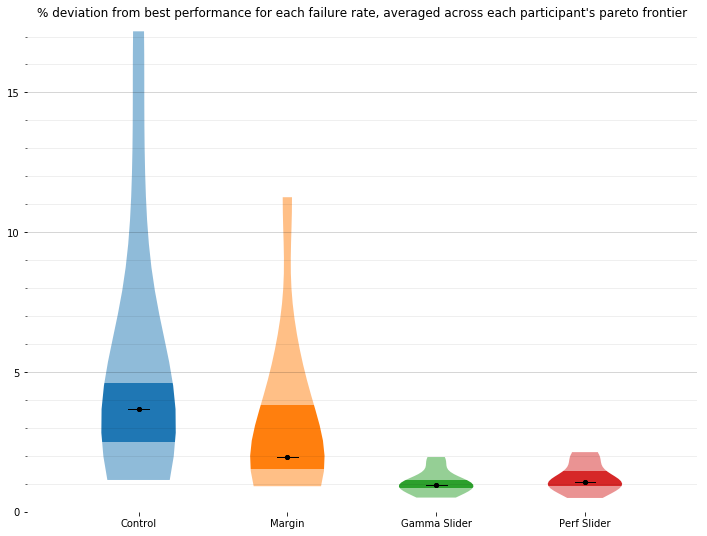

In [105]:
from collections import defaultdict
percents = defaultdict(list)
for condition, folder in zip(conditions, folder_names):   
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        pps = pareto({point: idn for point in points})
        total_percent_delta = 0
        for perf, fail in pps:
            total_percent_delta += perf/fail_perfs[fail] - 1
        total_percent_delta /= len(pps)
        print "  %2s  " % idn.split()[2][:-1], "%4.1f%%" % (100*total_percent_delta)
        percents[condition].append(100*total_percent_delta)
    print

fig, ax = subplots(figsize=(12,9), facecolor="white")
print [condition for condition in conditions]
data = [percents[condition] for condition in conditions]
plots = ax.violinplot(data, points=20, showextrema=False, showmedians=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, body in enumerate(plots["bodies"]):
    body.set_facecolor(colors[i])
    body.set_edgecolor("none")
    body.set_alpha(1)
for i, l in enumerate(data):
    l = array(l)
    lo = nanpercentile(l, 25, interpolation="linear")
    med = nanmedian(l)
    plot([i+0.93, i+1.07], [med, med], "-k", linewidth=1.0)
    plot([i+1, i+1], [med, med], "ok", markersize=4)
    hi = nanpercentile(l, 75, interpolation="linear")
    print conditions[i], lo, med, hi
    ax.fill_between([i+0.5, i + 1.5], hi, max(l), alpha=0.5,
                    edgecolor="none", facecolor="white")
    ax.fill_between([i+0.5, i + 1.5], 0, lo, alpha=0.5,
                    edgecolor="none", facecolor="white")
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

set_axis_style(ax, conditions)
title("% deviation from best performance for each failure rate, averaged across each participant's pareto frontier")
ylim([0, 17.5])
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="major", axis="y", alpha=0.125, color="black")
ax.grid(which='minor', axis="y", alpha=0.08, color="black")
plt.box(on=None)

Control

Margin

Gamma Slider

Perf Slider

['Control', 'Margin', 'Gamma Slider', 'Perf Slider']
Control 1.2768583769181718 2.579329830579591 4.522850309917964
Margin 0.5990876470318984 1.1975652655575986 3.5126596495744176
Gamma Slider 0.18922882932119744 0.5136145002195169 1.1910879736653723
Perf Slider 0.22595489417933656 0.565492908780052 1.3182128175519114


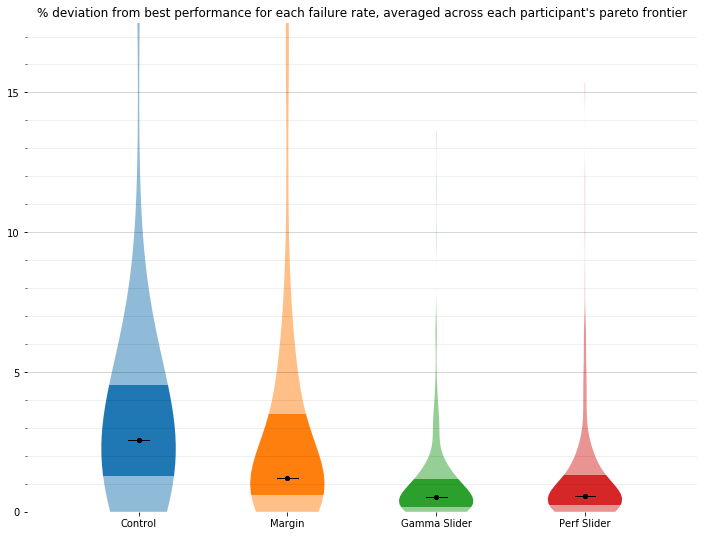

In [198]:
from collections import defaultdict
percents = defaultdict(list)
for condition, folder in zip(conditions, folder_names):   
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        pps = pareto({point: idn for point in points})
        total_percent_delta = 0
        for perf, fail in pps:
            percents[condition].append(100*(perf/fail_perfs[fail] - 1))
#             total_percent_delta += perf/fail_perfs[fail] - 1
#         total_percent_delta /= len(pps)
#         print "  %2s  " % idn.split()[2][:-1], "%4.1f%%" % (100*total_percent_delta)
#         percents[condition].append(100*total_percent_delta)
    print

fig, ax = subplots(figsize=(12,9), facecolor="white")
print [condition for condition in conditions]
data = [percents[condition] for condition in conditions]
plots = ax.violinplot(data, points=100, showextrema=False, showmedians=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, body in enumerate(plots["bodies"]):
    body.set_facecolor(colors[i])
    body.set_edgecolor("none")
    body.set_alpha(1)
for i, l in enumerate(data):
    l = array(l)
    lo = nanpercentile(l, 25, interpolation="linear")
    med = nanmedian(l)
    plot([i+0.93, i+1.07], [med, med], "-k", linewidth=1.0)
    plot([i+1, i+1], [med, med], "ok", markersize=4)
    hi = nanpercentile(l, 75, interpolation="linear")
    print conditions[i], lo, med, hi
    ax.fill_between([i+0.5, i + 1.5], hi, max(l), alpha=0.5,
                    edgecolor="none", facecolor="white")
    ax.fill_between([i+0.5, i + 1.5], 0, lo, alpha=0.5,
                    edgecolor="none", facecolor="white")
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

set_axis_style(ax, conditions)
title("% deviation from best performance for each failure rate, averaged across each participant's pareto frontier")
ylim([0, 17.5])
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="major", axis="y", alpha=0.125, color="black")
ax.grid(which='minor', axis="y", alpha=0.08, color="black")
plt.box(on=None)

Control
  33   40.1%
  11   46.6%
  26   33.5%
  17   126.8%
   7   52.5%
  32   28.6%
  16   211.7%
  23   25.6%
   1   13.2%
  38   45.8%

Margin
  34   59.4%
  10   137.0%
  30   14.3%
  28   23.9%
  22   10.7%
   5   18.0%
   2   19.0%
  42   63.7%
  39   33.4%
  19   24.6%
  15   18.9%

Gamma Slider
   3   23.2%
  12    7.0%
  37   21.0%
  29   14.3%
  18   13.3%
  41    5.9%
  27   10.8%
  13   11.7%
   6    9.6%
  21   10.8%
  36   12.1%

Perf Slider
   4   10.9%
  25    5.8%
  35   25.7%
  24   11.8%
   8   20.8%
  43   15.5%
  31   12.7%
  14    8.8%
  40   14.4%
  20   11.4%
   9   24.2%

['Control', 'Margin', 'Gamma Slider', 'Perf Slider']
Control 29.80491766107153 42.92456119627774 51.015578880418225
Margin 18.430836613397535 23.86375105475767 46.40067456335393
Gamma Slider 10.175475422306112 11.65055479278815 13.81131323232525
Perf Slider 11.13019822895318 12.727078890984947 18.12862917460496


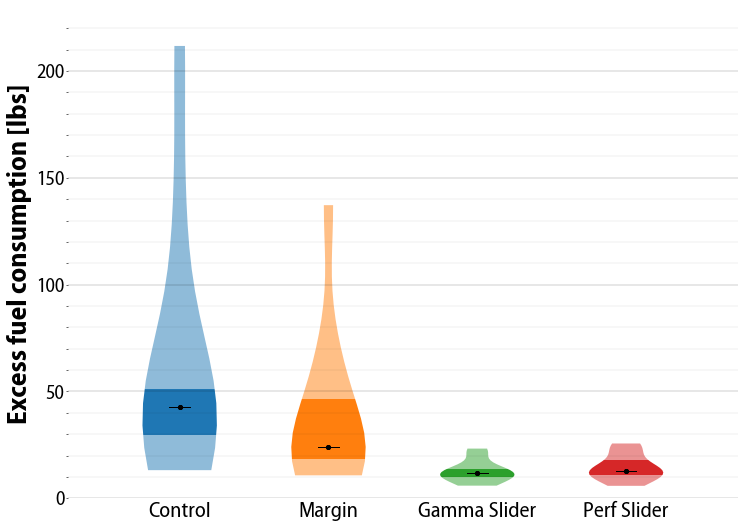

In [91]:
from collections import defaultdict
percents = defaultdict(list)
for condition, folder in zip(conditions, folder_names):   
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        pps = pareto({point: idn for point in points})
        total_percent_delta = 0
        for perf, fail in pps:
            total_percent_delta += perf - fail_perfs[fail]
        total_percent_delta /= len(pps)
        print "  %2s  " % idn.split()[2][:-1], "%4.1f%%" % (total_percent_delta)
        percents[condition].append(total_percent_delta)
    print

fig, ax = subplots(figsize=(12,9), facecolor="white")
print [condition for condition in conditions]
data = [percents[condition] for condition in conditions]
plots = ax.violinplot(data, points=20, showextrema=False, showmedians=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, body in enumerate(plots["bodies"]):
    body.set_facecolor(colors[i])
    body.set_edgecolor("none")
    body.set_alpha(1)
for i, l in enumerate(data):
    l = array(l)
    lo = nanpercentile(l, 25, interpolation="linear")
    med = nanmedian(l)
    plot([i+0.93, i+1.07], [med, med], "-k", linewidth=1.0)
    plot([i+1, i+1], [med, med], "ok", markersize=4)
    hi = nanpercentile(l, 75, interpolation="linear")
    print conditions[i], lo, med, hi
    ax.fill_between([i+0.5, i + 1.5], hi, max(l), alpha=0.5,
                    edgecolor="none", facecolor="white")
    ax.fill_between([i+0.5, i + 1.5], 0, lo, alpha=0.5,
                    edgecolor="none", facecolor="white")
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

set_axis_style(ax, conditions)
ylim([0, 229])
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ylabel("Excess fuel consumption [lbs]", fontweight="bold")
mpl.rcParams["xtick.labelsize"] = 22
ax.grid(which="major", axis="y", linewidth=0.125, color="black")
ax.grid(which='minor', axis="y", linewidth=0.0625, color="black")
plt.box(on=None)

Control

Margin

Gamma Slider

Perf Slider

['Control', 'Margin', 'Gamma Slider', 'Perf Slider']
Control 14.013972959811781 29.990365203512738 51.08157454295457
Margin 6.834786952337367 13.443044922966465 41.15592760919736
Gamma Slider 2.0306938512843544 5.7889429374015435 13.739949360634796
Perf Slider 2.3185420277704907 6.378558296951269 15.095971669651362


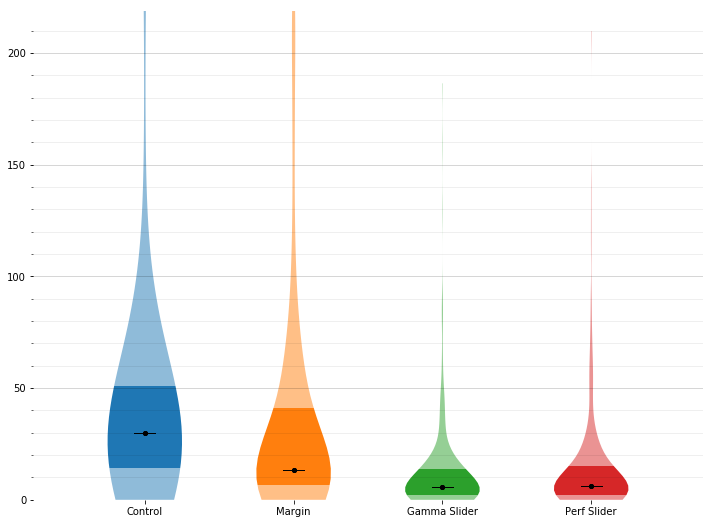

In [34]:
from collections import defaultdict
percents = defaultdict(list)
for condition, folder in zip(conditions, folder_names):   
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        pps = pareto({point: idn for point in points})
        total_percent_delta = 0
        for perf, fail in pps:
            percents[condition].append(perf - fail_perfs[fail])
#             total_percent_delta += perf - fail_perfs[fail]
#         total_percent_delta /= len(pps)
#         print "  %2s  " % idn.split()[2][:-1], "%4.1f%%" % (total_percent_delta)
#         percents[condition].append(total_percent_delta)
    print

# print percents
fig, ax = subplots(figsize=(12,9), facecolor="white")
print [condition for condition in conditions]
data = [percents[condition] for condition in conditions]
plots = ax.violinplot(data, points=100, showextrema=False, showmedians=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, body in enumerate(plots["bodies"]):
    body.set_facecolor(colors[i])
    body.set_edgecolor("none")
    body.set_alpha(1)
for i, l in enumerate(data):
    l = array(l)
    lo = nanpercentile(l, 25, interpolation="linear")
    med = nanmedian(l)
    plot([i+0.93, i+1.07], [med, med], "-k", linewidth=1.0)
    plot([i+1, i+1], [med, med], "ok", markersize=4)
    hi = nanpercentile(l, 75, interpolation="linear")
    print conditions[i], lo, med, hi
    ax.fill_between([i+0.5, i + 1.5], hi, max(l), alpha=0.5,
                    edgecolor="none", facecolor="white")
    ax.fill_between([i+0.5, i + 1.5], 0, lo, alpha=0.5,
                    edgecolor="none", facecolor="white")
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

set_axis_style(ax, conditions)
# title("Performance left on the table by each point in each user's pareto frontier")
ylim([0, 219])
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.grid(which="major", axis="y", alpha=0.125, color="black")
ax.grid(which='minor', axis="y", alpha=0.08, color="black")
plt.box(on=None)

Control

Margin

Gamma Slider

Perf Slider

['Control', 'Margin', 'Gamma Slider', 'Perf Slider']
Control 2.0 5.0 8.75
Margin 0.0 2.0 5.0
Gamma Slider 0.0 1.0 2.0
Perf Slider 0.0 1.0 2.0


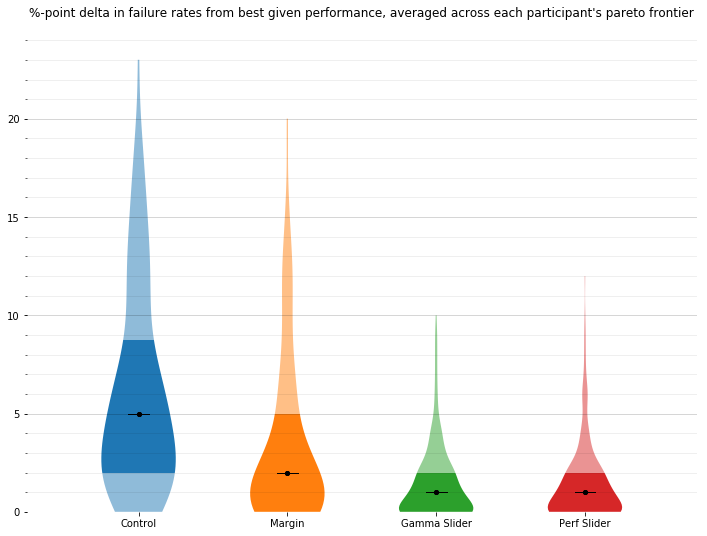

In [195]:
from collections import defaultdict
percents = defaultdict(list)
for condition, folder in zip(conditions, folder_names):   
    print condition
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        pps = pareto({point: idn for point in points})
        total_percent_delta = 0
        for perf, fail in pps:
            percents[condition].append(fail - perf_fails(perf))
#         total_percent_delta /= float(len(pps))
#         print "  %2s  " % idn.split()[2][:-1], "%4.1f%%" % (total_percent_delta)
#         percents[condition].append(total_percent_delta)
    print

fig, ax = subplots(figsize=(12,9), facecolor="white")
print [condition for condition in conditions]
data = [percents[condition] for condition in conditions]
plots = ax.violinplot(data, points=100, showextrema=False, showmedians=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, body in enumerate(plots["bodies"]):
    body.set_facecolor(colors[i])
    body.set_edgecolor("none")
    body.set_alpha(1)
for i, l in enumerate(data):
    l = array(l)
    lo = nanpercentile(l, 25, interpolation="linear")
    med = nanmedian(l)
    plot([i+0.93, i+1.07], [med, med], "-k", linewidth=1.0)
    plot([i+1, i+1], [med, med], "ok", markersize=4)
    hi = nanpercentile(l, 75, interpolation="linear")
    print conditions[i], lo, med, hi
    ax.fill_between([i+0.5, i + 1.5], hi, max(l), alpha=0.5,
                    edgecolor="none", facecolor="white")
    ax.fill_between([i+0.5, i + 1.5], 0, lo, alpha=0.5,
                    edgecolor="none", facecolor="white")
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

set_axis_style(ax, conditions)
title("%-point delta in failure rates from best given performance, averaged across each participant's pareto frontier")
ylim([0, 24.9])
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="major", axis="y", alpha=0.125, color="black")
ax.grid(which='minor', axis="y", alpha=0.08, color="black")
plt.box(on=None)

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


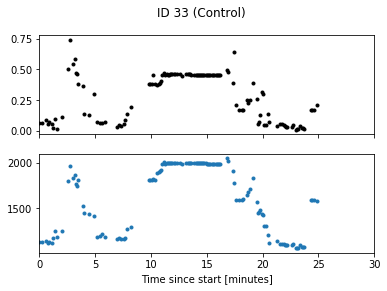

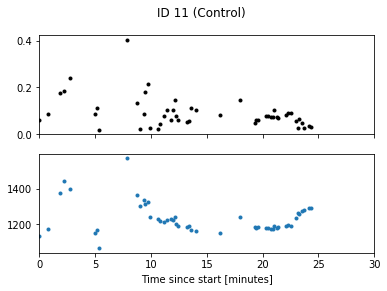

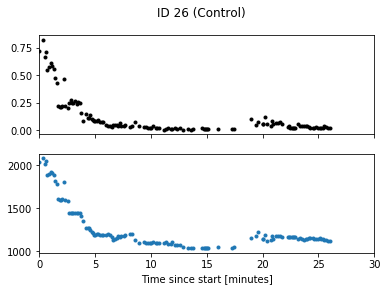

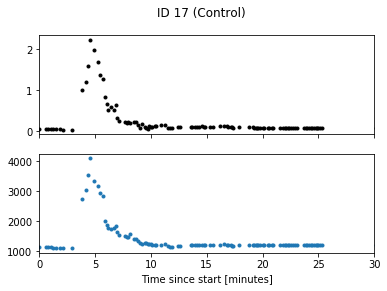

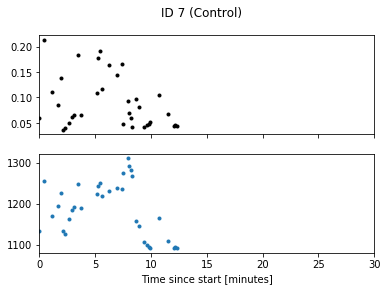

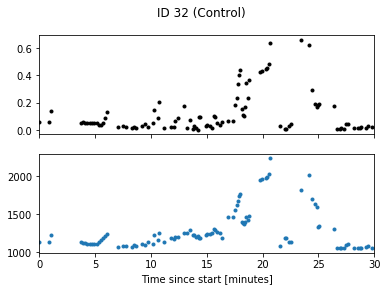

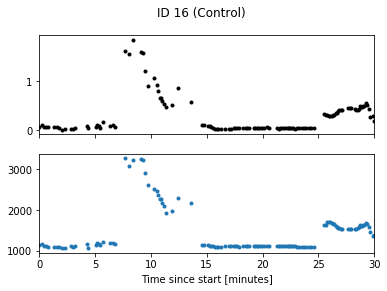

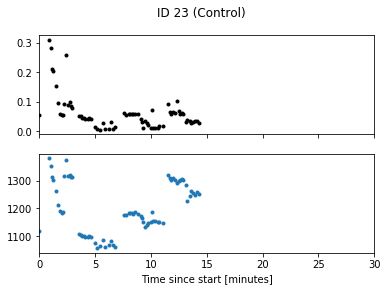

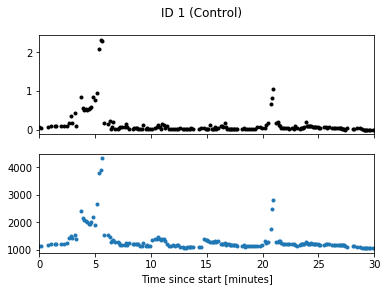

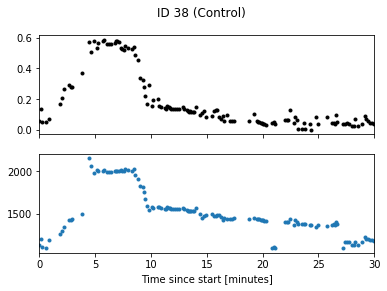

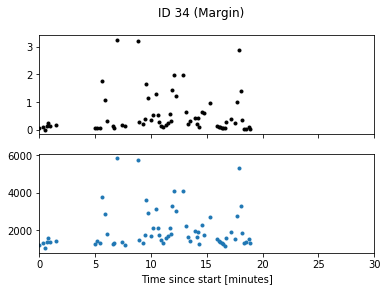

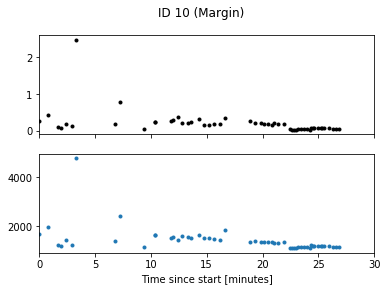

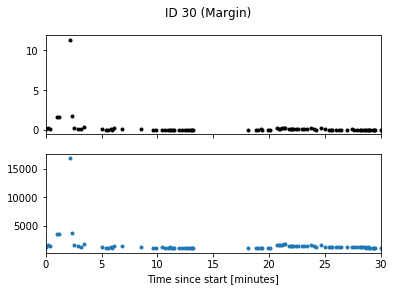

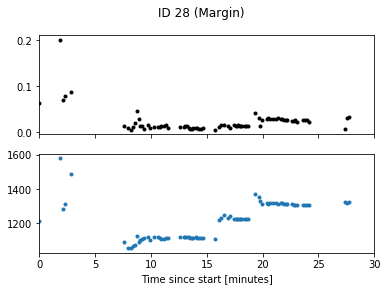

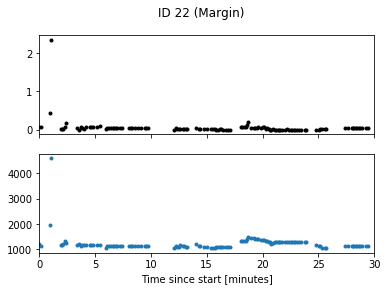

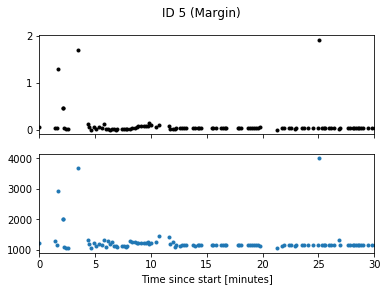

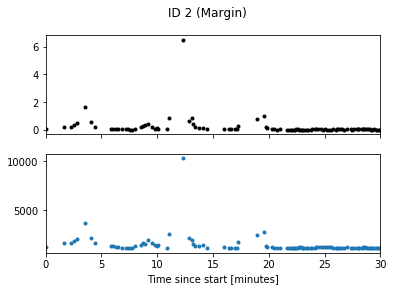

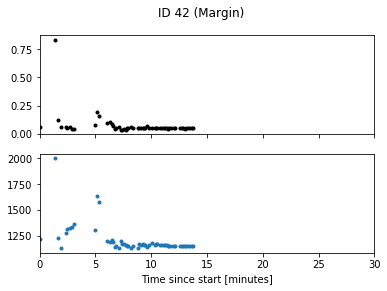

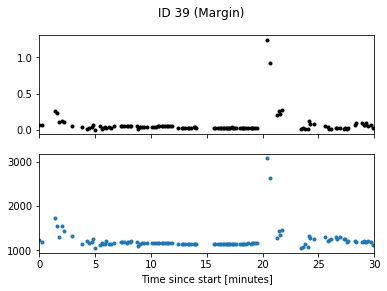

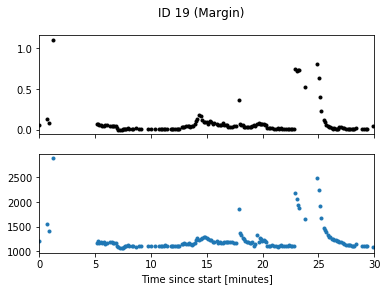

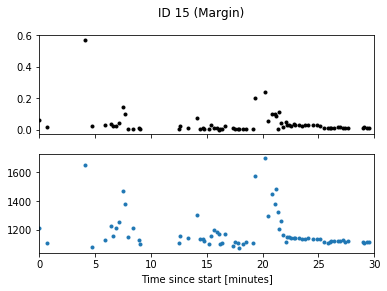

In [8]:
from collections import defaultdict

for condition, folder in zip(conditions, folder_names)[:2]:
    pointids, idpoints, pointnum, skipped = corrected_points(folder)
    for idn, points in idpoints.items():
        times = []
        for point in points:
            times.append(int(pointnum[point+(idn,)]))
        metric = [perf/fail_perfs[fail] - 1 for perf, fail in points]
        fig, (ax1, ax2) = subplots(2, 1, sharex=True, figsize=(6,4), facecolor="white")
        times = array(times) - times[0]
        ax1.plot(times/60., metric, "k.")
#         ax1.set_ylim([0, 0.5])
        ax2.plot(times/60., [perf for perf, _ in points], ".")
        ax2.set_xlabel("Time since start [minutes]")
        ax2.set_xlim([0, 30])
        fig.suptitle(" ".join(idn.split()[1:])[1:-1] + " (%s)" % condition)
#         break